In [36]:
%matplotlib inline

import sys
import os
sys.path.append('C:/Users/samrari/ComputBuffer')

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import Normalize
from skimage import exposure, img_as_float, morphology
from PIL import Image
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D


from osgeo import gdal
import osr
import xml.etree.ElementTree as ET
from my_packages.My_Geoprocess import*

from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn import mixture
import itertools
from scipy import linalg


from sklearn.cluster import KMeans
from datetime import datetime


In [4]:
npzfile = np.load('TrainMatrix.npz')
TX, ClassifIndex = npzfile['arr_0'], npzfile['arr_1']

In [5]:
scaler = preprocessing.StandardScaler().fit(TX)
TX = np.array(scaler.transform(TX))

In [7]:
lowest_bic = np.infty
bic = []
aic = []
n_components_range = range(5, 10)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        print('process '+str(n_components)) 
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(TX)
        bic.append(gmm.bic(TX))
        aic.append(gmm.aic(TX))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
        

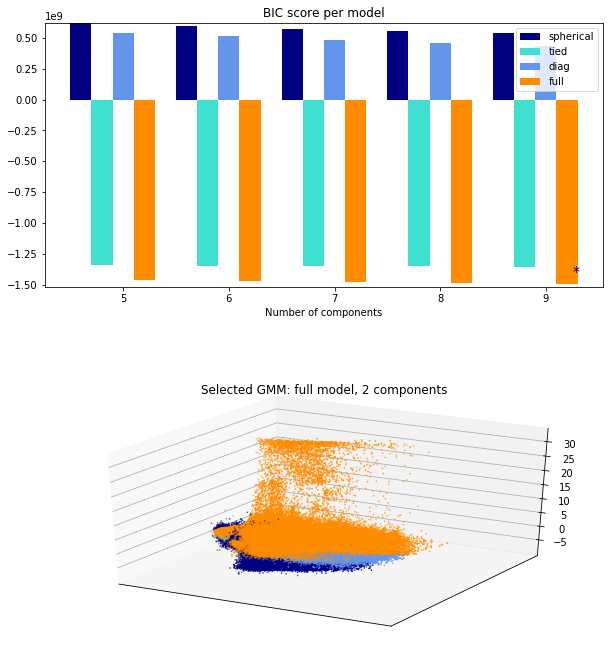

In [41]:
bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

fig = plt.figure(figsize=(10, 10))
# Plot the BIC scores
spl = fig.add_subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = (4) + np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = fig.add_subplot(2, 1, 2, projection='3d')
Y_ = clf.predict(TX)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    
    pca = PCA()
    TX_reduced = pca.fit(TX).transform(TX)
    splot.scatter(xs=TX_reduced[Y_ == i, 0],ys=TX_reduced[Y_ == i, 1], zs=TX_reduced[Y_ == i, 2], s=.4, color=color)

    '''
    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)'''

plt.xticks(())
plt.yticks(())
plt.title('Selected GMM: full model, 2 components')
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

In [33]:
lowest_bic

-1493934867.6132205

In [ ]:
kmeans.fit(np.float64(TX))

In [18]:
np.savez('Models/Models'+datetime.now().strftime('%Y-.%m-%d_%H.%M.%S')+'.npz', kmeans)

In [23]:
Y = kmeans.predict(np.float64(TX))

In [24]:
Y[Y==0]=16
np.unique(Y)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

Classe 1: 6.133421
Classe 2: 9.189815
Classe 3: 2.851350
Classe 4: 2.479999
Classe 5: 8.926305
Classe 6: 3.064755
Classe 7: 2.692793
Classe 8: 1.660626
Classe 9: 7.133942
Classe 10: 15.793043
Classe 11: 4.781498
Classe 12: 4.397994
Classe 13: 7.379569
Classe 14: 6.705160
Classe 15: 1.036346
Classe 16: 15.773384


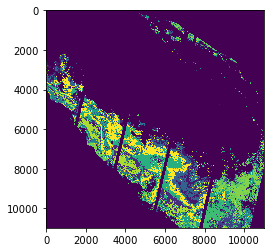

In [26]:
image = np.empty(ClassifIndex.shape, dtype=np.uint8)
image[ClassifIndex]= Y
plt.imshow(image)
for i in np.unique(Y):
    print('Classe {0:d}: {1:2f}'.format(i, 100*np.sum(Y==i)/len(Y)))

In [28]:
MaskPath = 'C:/Users/samrari/ComputBuffer/Image/Sen2/S2A_MSIL1C_20170718T231141_N0205_R101_T58KFA_20170718T231219.SAFE/Mask/'
SoilIndex = gdal.Open( MaskPath+'10m.tif')
geo_transform = SoilIndex.GetGeoTransform()
proj = SoilIndex.GetProjectionRef()

write_raster2('classtest16Clust.tif', image, geo_transform, proj, DriverName="GTiff", formatMem=gdal.GDT_UInt16)

In [23]:
def kmeans_missing(X, n_clusters, max_iter=10):
    """Perform K-Means clustering on data with missing values.

    Args:
      X: An [n_samples, n_features] array of data to cluster.
      n_clusters: Number of clusters to form.
      max_iter: Maximum number of EM iterations to perform.

    Returns:
      labels: An [n_samples] vector of integer labels.
      centroids: An [n_clusters, n_features] array of cluster centroids.
      X_hat: Copy of X with the missing values filled in.
    """

    # Initialize missing values to their column means
    missing = ~np.isfinite(X)
    mu = np.nanmean(X, 0, keepdims=1)
    X_hat = np.where(missing, mu, X)

    for i in range(max_iter):
        if i > 0:
            # initialize KMeans with the previous set of centroids. this is much
            # faster and makes it easier to check convergence (since labels
            # won't be permuted on every iteration), but might be more prone to
            # getting stuck in local minima.
            cls = KMeans(n_clusters, init=prev_centroids)
        else:
            # do multiple random initializations in parallel
            cls = KMeans(n_clusters, n_jobs=-1)

        # perform clustering on the filled-in data
        labels = cls.fit_predict(X_hat)
        centroids = cls.cluster_centers_

        # fill in the missing values based on their cluster centroids
        X_hat[missing] = centroids[labels][missing]

        # when the labels have stopped changing then we have converged
        if i > 0 and np.all(labels == prev_labels):
            break

        prev_labels = labels
        prev_centroids = cls.cluster_centers_

    return labels, centroids, X_hat

In [24]:
Y = kmeans.fit(np.float64(TX))

MemoryError: 

In [ ]:
X = bands_data[~SoilIndex]
X = np.hstack((tX,Features_Product(X),Features_Ratio(X)))
X = np.array(scaler2.transform(X))
X = np.array(pca.transform(X)[:,0:numberOfFeatures])

X.shape